In [1]:
import numpy as np
import cv2
from vidstab import VidStab
from os import listdir
import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
tf.compat.v1.disable_eager_execution()
import skimage 
from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter
from progressbar import ProgressBar
import seaborn as sns
sns.set_style("whitegrid")

#### Train an autoencoder to predict a frame 0.5 seconds in the future, given the original frame.

In [2]:
### Helper Methods 
def clean_str(name):
    return name.split("/ima")[0]

def get_crop_idx(img):
    m,n = img.shape
    new_size = 130
    x_coord, y_coord, radius = get_best_circle(img)
    idx_x_l = x_coord - new_size
    idx_x_r = x_coord + new_size
    idx_y_l = y_coord - new_size
    idx_y_r = y_coord + new_size
    if(idx_y_l< 0):
        diff = 0 - idx_y_l
        idx_y_l = 0
        idx_y_r = idx_y_r+ diff
    if(idx_y_r>m):
        diff = idx_y_r - m
        idx_y_r = m
        idx_y_l = idx_y_l - diff
    if(idx_x_l < 0):
        diff = 0 - idx_x_l
        idx_x_l = 0
        idx_x_r = idx_x_r+ diff
    if(idx_x_r > n):
        diff = idx_x_r - n
        idx_x_r = n
        idx_x_l = idx_x_l - diff
    return (idx_x_l,idx_x_r,idx_y_l, idx_y_r,new_size*2)
        
        


def last_4chars(x):
    suf = x.split("_")[1]
    inte = int(suf.split(".")[0])
    return inte

def getFrame(sec,path,stable_vid_name,count):
    vidcap = cv2.VideoCapture(stable_vid_name)
    vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
    hasFrames,image = vidcap.read()
    if hasFrames:
        cv2.imwrite(path+"/image_"+str(count)+".jpg", image)     # save frame as JPG file
    return hasFrames

    
def list_files1(directory, extension):
    """
    list_files1: Find files with a certain extension in the directory and return the names in a list
            Args:
                directory: Directory to be searched
                extension: the extension of the files
            Returns:
                List of files with the extension within the directory
    """
    return list(( (directory + f) for f in listdir(directory) if f.endswith('.' + extension)))

def generate_frames_vid():
    """
    generate_frames_vid: Generates frames for every video in listvideos, and save them in folder with
                         name vidName/
                    Args:
                        listvideos: List containing the path to the video files
                    Returns:
                        None
    """
    try:
        os.mkdir("StableFrames", 755)
    except OSError:
        pass
    try:
        os.mkdir("StableFrames/videos", 755)
    except OSError:
        pass
    listvideos = list_files1('videos/','avi')
    for video in listvideos:
        path = "StableFrames/" + video.split('.avi')[0]
        try:
            os.mkdir(path, 755)
        except OSError:
            pass
        stable_vid_name = 'stable_video.avi'
        stabilizer = VidStab(kp_method='DENSE')
        stabilizer.stabilize(input_path=video, output_path=stable_vid_name)
        sec = 0
        frameRate = 0.5 #//it will capture image in each 0.5 second
        count=1
        success = getFrame(sec,path,stable_vid_name,count)
        while success:
            count = count + 1
            sec = sec + frameRate
            sec = round(sec, 2)
            success = getFrame(sec,path,stable_vid_name,count)
 
### Generate train_test data
def generate_train_testdata(k):
    """
    generate_train_testdata: Generate table for path to input and output data
                        Args:
                            k: Distance for the next frame
                        Returns:
                             df containg the input path and the corresponding output predicted
    """
    data = pd.DataFrame(columns=["input", "output"])
    directory = "StableFrames/videos"
    subdir = listdir(directory)
    for subd in subdir:
        images = sorted(listdir(directory + "/" + subdir[0]), key=last_4chars)
        for idx, img in enumerate(images):
            base_path = directory + "/" + subd + "/"
            input_img = base_path + img
            output_img = base_path + "image_" + str(idx+k+1) + ".jpg"
            if os.path.isfile(output_img):
                temp_df = pd.DataFrame([[input_img,output_img]], columns=["input", "output"])
                data =  pd.concat((data,temp_df))
    return data     



def get_best_circle(img1):
    """
    get_best_circle: Use hough transform to find the best circle
                Args: 
                     img1: Grayscale image on which to find the circle
                Returns:
                    circle: list containing the x-coords, y-coords of the center
                            and radius for the circle. 
    """
    edges = canny(img1, sigma=2, low_threshold=10, high_threshold=50)
    hough_radii = np.arange(50, 150, 2)
    hough_res = hough_circle(edges, hough_radii)
    accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii,
                                               total_num_peaks=3)
    max_idx = np.argmax(radii)
    max_x = cx[max_idx]
    max_y = cy[max_idx]
    max_radii = radii[max_idx]
    return ([max_x, max_y, max_radii])

def preprocess_image_seg(img1):
    """
    preprocess_image: Find the relevant information, and shift to the center
    
                Args:
                    img1: Image on which to perform the preprocessing
                Returns:
                    masked_img: Image with preprocessing done
    
    """
    idx_x_l,idx_x_r,idx_y_l, idx_y_r,new_size = get_crop_idx(img1)
    new_img = img1[idx_y_l:idx_y_r,idx_x_l:idx_x_r]
    return (new_img,new_size)
    

def get_layers(mainModel, start_idx, end_idx, need_summary= False):
    """
    get_layers: get Layers from start_idx to end_idx, and return a new model extracts layers
                from start_idx to end_idx
            Args:
                mainModel: The model from which to extract layers
                start_idx: start_idx to extract
                end_idx  : end_idx to extract
            need_summary : If we need the summary
            Returns:
                model: New Model with extracted layers
    
    """
    model = tf.keras.Sequential()
    for i in range(start_idx, end_idx+1):
        model.add(mainModel.get_layer(index = i))
    if(need_summary):
        model.summary()
    return model
    
def get_embeddings(train_imgs, mainModel, start_idx, end_idx):
    """
    get_embeddings: Get embeddings for train_imgs after extracting layers from mainModel
                    from start_idx to end_idx
                Args:
                    train_imgs: Images to get embeddings from
                    mainModel: The model from which to extract layers
                    start_idx: start_idx to extract
                    end_idx  : end_idx to extract
                Returns:
                    nothing
    """
    m = train_imgs.shape[0]
    embedding_model = get_layers(mainModel, 0,5)
    embeddings = embedding_model.predict(train_imgs)
    embeddings = embeddings.reshape(m,2)
    return embeddings


        
def only_read(X):
    """
    read_from_path: Read images from path, preprocess, and append to numpy data frame.
                Args:
                    X: List containing all the paths
                Returns:
                    data: numpy array containing all of the data
    """
    img_size = 500
    new_img_size = 260
    data = np.empty(shape = [1,new_img_size,new_img_size])
    pbar = ProgressBar()
    print("Starting Reading and Preprocessing.\n")
    
    for i in pbar(X):
        img = cv2.imread(i, 0)
        img,new_size = preprocess_image_seg(img)
        img = img.reshape(1,new_size,new_size)
        data = np.append(data,img, axis = 0)
    print("Done Reading and Preprocessing.\n")
    data = data.reshape(len(X)+1,new_size,new_size,1)
    return data


#### Generate the train and test data frame video
##### Procedure is as follows
- generate_frame_vid generates the image to be use for training from the video files, after stabalizing the video using "DENSE" method
- we use generate_train_testdata to contain the path of the image as input, and the output as the frame frame_dist frame in the future
- We then preprocess the image. First we use hough transform to find circles within a radius from 50 to 150. We use the maximum of these circles as after trial and error we foudn this to be a good method to extract the frame we are interested in 
- Next we crop this image to get only the circle of interest and a few pixels around it using the center location of the circle

In [3]:
#generate_frames_vid()
frame_dist = 2
train_test_data = generate_train_testdata(frame_dist)  

In [4]:
inp = train_test_data.iloc[:,0].values.tolist()
inp_d = only_read(inp)
out = train_test_data.iloc[:,1].values.tolist()
out_d = only_read(out)

#Get shape
m = inp_d.shape[0]
img_size = 260
inp_d = inp_d[1:m,:,:,0].reshape(m-1,img_size,img_size,1)
out_d = out_d[1:m,:,:,0].reshape(m-1,img_size,img_size,1)

Starting Reading and Preprocessing.



100% |########################################################################|


Done Reading and Preprocessing.

Starting Reading and Preprocessing.



Done Reading and Preprocessing.



#### Training and Plots
- We define an encoder decoder model that after performing convolutions and pooling is reshaped into a dense layer, we the add a Dense layer with 2 nodes to get the embeddings which are visualized further. We then add a dense layer of img_size^2 which is then reshaped into the output image size. THE MODEL SUMMARY CAN BE FOUND BELOW.
- For getting the embeddings we run the input image through the neural network, and get the output at the Dense layer with 2 nodes. These are further plotted to visualize how the embeddings look for different videos

In [5]:
def encoder_decoder(img_size):
    model = tf.keras.Sequential()
    ###Encoder
    model.add(tf.keras.layers.Conv2D(filters = 128, kernel_size = 6,strides=2, padding = "valid",
                                     activation = "relu", input_shape = (img_size,img_size,1),
                                     kernel_initializer = tf.keras.initializers.glorot_normal(seed=15),
                                     name= "layer1"))
    model.add(tf.keras.layers.MaxPool2D(3, strides=2, padding="valid", name = "pool1"))
    model.add(tf.keras.layers.Conv2D(filters =  6, kernel_size = 6,strides=2, padding = "valid",
                                     activation = "relu",
                                     kernel_initializer = tf.keras.initializers.glorot_normal(seed=15),
                                     name= "layer2"))
    model.add(tf.keras.layers.MaxPool2D(3, strides=2, padding="valid", name = "pool2"))
    
    model.add(tf.keras.layers.Reshape((1,1176)))
    model.add(tf.keras.layers.Dense(2, activation = "relu", 
                                    kernel_initializer = tf.keras.initializers.glorot_normal(seed=15)))
    model.add(tf.keras.layers.Dense(img_size*img_size, activation = "relu",
                                    kernel_initializer = tf.keras.initializers.glorot_normal(seed=15)))
    model.add(tf.keras.layers.Reshape((img_size,img_size,1)))
    
    model.summary()
    model.compile(optimizer=tf.keras.optimizers.Adam(0.0005),
              loss='mean_squared_error',
              metrics=['mae'])

    return model

In [6]:
encoder = encoder_decoder(img_size)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Conv2D)              (None, 128, 128, 128)     4736      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 63, 63, 128)       0         
_________________________________________________________________
layer2 (Conv2D)              (None, 29, 29, 6)         27654     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 14, 14, 6)         0         
_________________________________________________________________
reshape (Reshape)            (None, 1, 1176)           0         
_________________________________________________________________
dense (Dense)                (None, 1, 2)              2354      
_________________________________________

In [7]:
batch_size = 32
epochs = 1000
validation_split = 0.1
encoder.fit(x = inp_d, y = out_d, batch_size = batch_size, epochs=epochs,
            validation_split=validation_split, verbose=0)


In [ ]:
print("Training Loss is : ", encoder.history.history['loss'][999])
print("Validation loss is : ",encoder.history.history['val_loss'][999])
print("train Mae loss is : ",encoder.history.history['mae'][999])
print("val mae is : ", encoder.history.history['val_mae'][999])

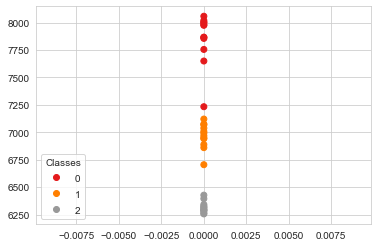

In [8]:
## Get embeddings
embeds = get_embeddings(inp_d, encoder, 0,5)
vid_names  = pd.get_dummies(train_test_data.input.apply(clean_str)).values
vid_class = vid_names.argmax(axis=1)
## Scatter plot for embeddings 
fig, ax = plt.subplots()
scatter = ax.scatter(embeds[:,0], embeds[:,1], c=vid_class, cmap="Set1")
legend1 = ax.legend(*scatter.legend_elements(), loc="lower left", title="Classes")


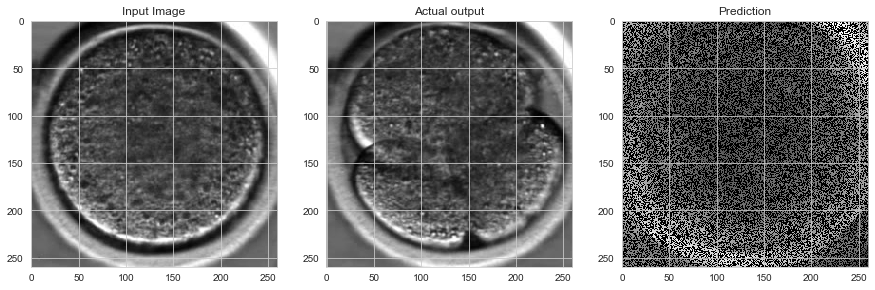

In [9]:
idx = 1
input_img = inp_d[idx,:,:,0].reshape(1,img_size,img_size,1)
output_img = out_d[idx,:,:,0]
pred = encoder.predict(input_img).reshape(img_size,img_size)
plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.title("Input Image")
plt.imshow(input_img.reshape(img_size,img_size),cmap="gray")
plt.subplot(1,3,2)
plt.title("Actual output")
plt.imshow(output_img,cmap="gray")
plt.subplot(1,3,3)
plt.title("Prediction")
plt.imshow(pred,cmap="gray")

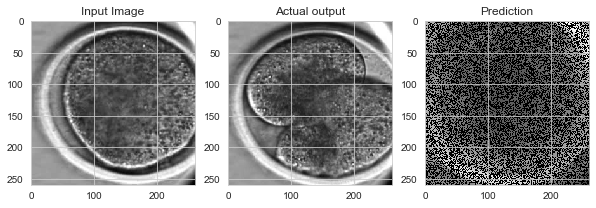

In [10]:
idx = 12
input_img = inp_d[idx,:,:,0].reshape(1,img_size,img_size,1)
output_img = out_d[idx,:,:,0]
pred = encoder.predict(input_img).reshape(img_size,img_size)
plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.title("Input Image")
plt.imshow(input_img.reshape(img_size,img_size),cmap="gray")
plt.subplot(1,3,2)
plt.title("Actual output")
plt.imshow(output_img,cmap="gray")
plt.subplot(1,3,3)
plt.title("Prediction")
plt.imshow(pred,cmap="gray")